# Imports y configuraciones básicas

Algunos imports que se utilizarán en el resto del notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bwb.distributions import *
from bwb.utils import plot_list_of_draws, plot_histogram_from_points

import pandas as pd
import itertools

In [2]:
# import logging
# log = logging.getLogger("bwb.distributions")
# log.setLevel(logging.DEBUG)

Importamos los datos del archivo de Google Cloud

In [3]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Haremos dos listas de caritas: una sin modificación, y otra con modificación.

In [4]:
%%time

CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)
    
    
# Conjuntos de caritas con soporte no-nulo
dist_draw_builder.set_ceil(CEIL)
    
faces_modified = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_modified.append(dd_arr)
    
len(faces_original), len(faces_modified)

CPU times: total: 9.53 s
Wall time: 9.58 s


(161666, 161666)

`faces_original` son las caritas sin modificar el soporte, mientras que `faces_modified` es con los que tiene soporte no-nulo.

Obtendremos la data $D = \{x_i\}_{i=1}^{n}\subseteq\mathcal{X}^n$, y probaremos los métodos para distintos valores de $n$.

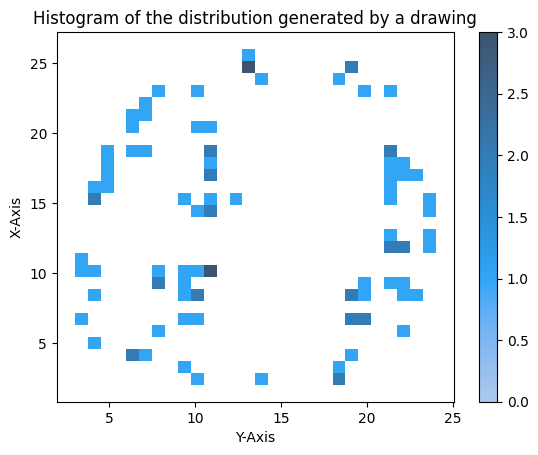

In [5]:
first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=100)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

In [6]:
# Tiempo de cálculo del caché

De forma implícita, las clases `MetropolisPosteriorPiN` y `GibbsPosteriorPiN` hacen un pre-procesamiento para calcular a modo de caché todas las verosimilitudes. En este notebook se calcularán los tiempos de iniciación para calcular este caché, tanto para cada uno de los diferentes métodos como para la lista de conjunto de caritas originales y modificadas.

In [7]:
%%script false --no-raise-error
# %%time
# %%script false --no-raise-error


def fmt_avg_stdev(avg, stdev):
    return f"{avg:.4f} ± {stdev:.4f}"


resume_df = pd.DataFrame()

n_list = [5, 25, 50, 100]

for n in n_list:
    kwargs = dict(data=x[:n], models=faces_original, seed=rng)
    
    print(f"Metropolis Original: {n = }")
    result = %timeit -o MetropolisPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time M. original [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    print(f"Gibbs Original: {n = }")
    result = %timeit -o GibbsPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time G. original [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    kwargs["models"] = faces_modified
    
    print(f"Metropolis Modified: {n = }")
    result = %timeit -o MetropolisPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time M. modified [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    print(f"Gibbs Modified: {n = }")
    result = %timeit -o GibbsPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time G. modified [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
print(resume_df.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Time M. original [seg]</th>
      <th>Time G. original [seg]</th>
      <th>Time M. modified [seg]</th>
      <th>Time G. modified [seg]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.3336 ± 0.0313</td>
      <td>0.3104 ± 0.0273</td>
      <td>0.6644 ± 0.0747</td>
      <td>0.5780 ± 0.0249</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.3312 ± 0.0139</td>
      <td>0.3304 ± 0.0190</td>
      <td>2.4187 ± 0.0504</td>
      <td>2.8125 ± 0.3133</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.4299 ± 0.0807</td>
      <td>0.4798 ± 0.1267</td>
      <td>4.8916 ± 0.1065</td>
      <td>4.8937 ± 0.2163</td>
    </tr>
    <tr>
      <th>100</th>
      <td>0.3456 ± 0.0264</td>
      <td>0.3423 ± 0.0157</td>
      <td>9.1654 ± 0.0452</td>
      <td>9.4425 ± 0.3818</td>
    </tr>
  </tbody>
</table>

Ahora queremos ver el número de muestras que se samplean de las distribuciones y el tiempo que se demora, como también el tiempo promedio que se demora por cada iteración y por cada método

In [42]:
# Tables
m_num_samples_original = pd.DataFrame()
m_total_time_original = pd.DataFrame()

g_num_samples_original = pd.DataFrame()
g_total_time_original = pd.DataFrame()

m_num_samples_modified = pd.DataFrame()
m_total_time_modified = pd.DataFrame()

g_num_samples_modified = pd.DataFrame()
g_total_time_modified = pd.DataFrame()

In [43]:
%%script false --no-raise-error
# %%time

# n-k lists
n_list = [5, 25, 50, 75]
k_list = [1, 50, 100, 500, 1000, 2500]


# Iterate over n/k
for n, k in itertools.product(n_list, k_list):
    kwargs = dict(data=x[:n], models=faces_original, seed=rng)
    
    
    print(f"Metropolis original {n = }, {k = }")
    mcmc = AlternativeMetropolisPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    m_num_samples_original.loc[n, k] = len(mcmc.counter)
    m_total_time_original.loc[n, k] = f"{result.average:.4f}"
    
    
    print(f"Gibbs original {n = }, {k = }")
    mcmc = AlternativeGibbsPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    g_num_samples_original.loc[n, k] = len(mcmc.counter)
    g_total_time_original.loc[n, k] = f"{result.average:.4f}"
    
    
    
    kwargs["models"] = faces_modified
    
    print(f"Metropolis modified {n = }, {k = }")
    mcmc = AlternativeMetropolisPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    m_num_samples_modified.loc[n, k] = len(mcmc.counter)
    m_total_time_modified.loc[n, k] = f"{result.average:.4f}"
    
    
    print(f"Gibbs modified {n = }, {k = }")
    mcmc = AlternativeGibbsPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    g_num_samples_modified.loc[n, k] = len(mcmc.counter)
    g_total_time_modified.loc[n, k] = f"{result.average:.4f}"
    
#     break

In [44]:
df = m_num_samples_original
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>12.0</td>
      <td>20.0</td>
      <td>101.0</td>
      <td>195.0</td>
      <td>441.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>3.0</td>
      <td>6.0</td>
      <td>3.0</td>
      <td>5.0</td>
      <td>16.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>

In [45]:
df = m_total_time_original
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0014</td>
      <td>0.0511</td>
      <td>0.1043</td>
      <td>0.6535</td>
      <td>1.1080</td>
      <td>2.9345</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0024</td>
      <td>0.0032</td>
      <td>0.0116</td>
      <td>0.0331</td>
      <td>0.0811</td>
      <td>0.1687</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0002</td>
      <td>0.0043</td>
      <td>0.0136</td>
      <td>0.0345</td>
      <td>0.0570</td>
      <td>0.1401</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0001</td>
      <td>0.0007</td>
      <td>0.0008</td>
      <td>0.0037</td>
      <td>0.0071</td>
      <td>0.0177</td>
    </tr>
  </tbody>
</table>

In [46]:
df = g_num_samples_original
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>97.0</td>
      <td>403.0</td>
      <td>738.0</td>
      <td>1405.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>5.0</td>
      <td>4.0</td>
      <td>5.0</td>
      <td>13.0</td>
      <td>15.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>

In [47]:
df = g_total_time_original
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0012</td>
      <td>0.0610</td>
      <td>0.1108</td>
      <td>0.6387</td>
      <td>1.0874</td>
      <td>3.2232</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0006</td>
      <td>0.0029</td>
      <td>0.0071</td>
      <td>0.0332</td>
      <td>0.0568</td>
      <td>0.1391</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0002</td>
      <td>0.0043</td>
      <td>0.0054</td>
      <td>0.0243</td>
      <td>0.0459</td>
      <td>0.1150</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0000</td>
      <td>0.0004</td>
      <td>0.0007</td>
      <td>0.0045</td>
      <td>0.0075</td>
      <td>0.0179</td>
    </tr>
  </tbody>
</table>

In [48]:
df = m_num_samples_modified
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>11.0</td>
      <td>13.0</td>
      <td>87.0</td>
      <td>203.0</td>
      <td>752.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>7.0</td>
      <td>9.0</td>
      <td>1.0</td>
      <td>17.0</td>
      <td>15.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>5.0</td>
      <td>8.0</td>
      <td>8.0</td>
      <td>12.0</td>
      <td>17.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>8.0</td>
      <td>9.0</td>
      <td>14.0</td>
      <td>7.0</td>
      <td>9.0</td>
    </tr>
  </tbody>
</table>

In [49]:
df = m_total_time_modified
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0162</td>
      <td>0.8749</td>
      <td>1.6367</td>
      <td>8.2336</td>
      <td>17.0771</td>
      <td>41.5876</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0155</td>
      <td>0.9267</td>
      <td>1.6738</td>
      <td>8.7581</td>
      <td>16.6361</td>
      <td>41.8724</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0155</td>
      <td>0.8342</td>
      <td>2.3497</td>
      <td>8.8038</td>
      <td>18.3098</td>
      <td>41.6662</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0151</td>
      <td>0.8028</td>
      <td>1.6917</td>
      <td>8.4317</td>
      <td>16.3477</td>
      <td>44.5841</td>
    </tr>
  </tbody>
</table>

In [50]:
df = g_num_samples_modified
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>100.0</td>
      <td>496.0</td>
      <td>970.0</td>
      <td>2364.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>40.0</td>
      <td>66.0</td>
      <td>228.0</td>
      <td>372.0</td>
      <td>654.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
    </tr>
  </tbody>
</table>

In [51]:
df = g_total_time_modified
print(df.to_html())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
    </tr>
  </thead>
  <tbody>
  </tbody>
</table>


""


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0165</td>
      <td>0.8765</td>
      <td>1.6155</td>
      <td>8.8067</td>
      <td>17.6119</td>
      <td>48.1437</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0161</td>
      <td>1.0321</td>
      <td>1.7492</td>
      <td>8.1357</td>
      <td>15.9913</td>
      <td>45.4067</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0155</td>
      <td>0.8066</td>
      <td>1.6997</td>
      <td>8.4641</td>
      <td>16.3566</td>
      <td>40.3777</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0160</td>
      <td>0.8029</td>
      <td>1.5783</td>
      <td>7.9070</td>
      <td>15.9652</td>
      <td>40.1593</td>
    </tr>
  </tbody>
</table>